In [3]:
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt

from project.data.preprocessed.unsplit import unsplit_data as UNSPLIT
from project.data.preprocessed.split import split_data as SPLIT
from project.utils.tokenize import nltk_tok

UNSPLIT = UNSPLIT()

TOTAL = []
TOTAL.extend(UNSPLIT.train)
TOTAL.extend(UNSPLIT.valid)
# TOTAL.extend(UNSPLIT.test)


## Documentation Investigations

In [4]:
def print_top_and_bottom(counter_obj, count, name, cols=2, width=35):
    mc = counter_obj.most_common()
    top_x = mc[:count]
    bottom_x = mc[-count:]
    
    top = "\n".join("{}. {}".format(i+1, x) for i,x in enumerate(top_x))
    bottom = "\n".join("{}. {}".format(i+1, x) for i,x in enumerate(reversed(bottom_x)))
    
    s = '''TOP {count} {name}\n{top}\nBOTTOM {count} {name}\n{bottom}'''.format(
        count=count, name=name, top=top, bottom=bottom
    )
    print(to_columns(s, cols, width))
    return mc

def to_columns(string, cols, width):
    lines = string.split("\n")
    lpc = int(len(lines) / cols)
    columns = [lines[i*lpc:(i+1)*lpc] for i in range(cols)]
    
    max_c = max([len(c) for c in columns])
    for c in columns:
        size = len(c)
        for i in range(max_c - size):
            c.append(" ")
    
    final_text = []
    for i in range(len(lines)):
        final_text.append(str.ljust(columns[i % cols][(i // cols)], width, " "))
        if i % cols == cols-1:
            final_text.append('\n')
    return "".join(final_text)

def get_histogram(counter, bins, name):
    counts = [n[1] for n in counter]
    total = sum(counts)
    args = len(counter)
    meta_counter = Counter(counts)
    
    h = np.histogram(counts, bins)

    lines = [ 
        "Histogram: {}".format(name),
        "\n",
        str.ljust("Bin", 10, " "),
        str.rjust("Count", 7, " "),
        str.rjust("% of names", 12, " "),
        str.rjust("% of vars", 10, " "), 
        str.rjust("%-ile vars ", 13, " "), 
        "\n",
    ]
    
    cumulative = 0 
    for i in range(1, len(h[1])-1):
        bucket_min, bucket_max = h[1][i], h[1][i+1] 
        lines.append(str.ljust("{}-{}".format(bucket_min, bucket_max), 10, " "))
        lines.append(str.rjust("{}".format(h[0][i]), 7, " "))
        lines.append(str.rjust("{:.3f}".format(100*h[0][i]/args), 11, " "))
        
        tot = 0
        for i in range(bucket_min, bucket_max):
            if i in meta_counter:
                tot += i * meta_counter[i]
        lines.append(str.rjust("{:.3f}".format(100*tot/total), 11, " "))
        cumulative += 100*tot/total
        lines.append(str.rjust("{:.2f}".format(cumulative), 11, " "))
        
        lines.append("\n")
    return "".join(lines)
        
        

In [5]:
TOP_N = 10
def counts():
    arg_names = Counter(x['arg_name'] for x in TOTAL)
    func_names = Counter(x['name'] for x in TOTAL)
    
    mc_arg_name = print_top_and_bottom(arg_names, TOP_N, "Argument Names")
    mc_func_name = print_top_and_bottom(func_names, TOP_N, "Function Names")
    
    name_bins =  [0,1,2,3,4,5,10,20,50,100,200,500,3000]
    name_h = get_histogram(mc_arg_name, name_bins, "Arg Names")
    func_bins =  [0,1,2,3,4,5,10,20,50,100,200]
    func_h = get_histogram(mc_func_name, name_bins, "Func Names")
    print(to_columns(name_h + '\n' + func_h , 2, 60))

        
counts()

TOP 10 Argument Names              BOTTOM 10 Argument Names           
1. ('name', 1917)                  1. ('partial_args', 1)             
2. ('x', 439)                      2. ('release_conn', 1)             
3. ('kwargs', 303)                 3. ('xfrm21', 1)                   
4. ('axis', 263)                   4. ('sparse_features', 1)          
5. ('dtype', 260)                  5. ('end_inclusive', 1)            
6. ('a', 230)                      6. ('xyz', 1)                      
7. ('G', 227)                      7. ('pool_timeout', 1)             
8. ('inputs', 224)                 8. ('line_length', 1)              
9. ('input', 223)                  9. ('root_source', 1)              
10. ('value', 210)                 10. ('stdoffset', 1)               

TOP 10 Function Names              BOTTOM 10 Function Names           
1. ('fit', 122)                    1. ('relabel_gexf_graph', 1)       
2. ('transform', 102)              2. ('note_number_to_drum_name', 1) 
3. ('

In [6]:
TOP_N = 20
def check_for_duplicates():
    div = "<!!S!!>"
    arg_names = Counter(x['arg_name'] + div + " ".join(nltk_tok(x['arg_desc'])) for x in TOTAL)
    mc = arg_names.most_common()
    print("Check for Unique [Arg, Desc]\n")
    print("{}".format("N. Count  [Arg, Desc]"))
    
    for i, (arg_desc, c) in enumerate(mc[:TOP_N]):
        line = [
            str.ljust("{}".format(i+1), 3, " "),
            str.ljust("{}".format(c), 7, " "),
            "{}".format(arg_desc.split(div)),
            "\n"
        ]
        print("".join(line))
        
    print()
    print()
    name_bins =  [0,1,2,3,4,5,10,20,50,100,200,3000]
    name_h = get_histogram(mc, name_bins, "Unique Names + Desc")
    print(name_h)
    
check_for_duplicates()

Check for Unique [Arg, Desc]

N. Count  [Arg, Desc]
1  1057   ['name', 'a name for the operation ( optional ) .']

2  95     ['retry', 'a retry object used to retry requests . if `` none `` is specified , requests will not be retried .']

3  83     ['timeout', 'the amount of time , in seconds , to wait for the request to complete . note that if `` retry `` is specified , the timeout applies to each individual attempt .']

4  69     ['name', 'optional op name .']

5  59     ['options', 'overrides the default settings for this call , e.g , timeout , retries etc .']

6  57     ['G', 'a networkx graph']

7  44     ['image', 'input image .']

8  41     ['name', 'an optional variable_scope name .']

9  39     ['random_state', 'if int , random_state is the seed used by the random number generator ; if randomstate instance , random_state is the random number generator ; if none , the random number generator is the randomstate instance used by ` np.random ` .']

10 37     ['name', 'a name for t

In [7]:

def count_descs_per_arg():
    ARGS= 10
    TOP_DESC = 5
    
    arg_names = Counter(x['arg_name'] for x in TOTAL)
    mc = arg_names.most_common()
    
    tally = {}
    for d in TOTAL:
        name = d['arg_name']
        if name in tally:
            tally[name]["desc"].append(d['arg_desc'].lower())
            tally[name]["pkg"].append(d['pkg'])
        else:
            tally[name] = {"desc": [d['arg_desc']], "pkg": [d['pkg']]}
    
    tuple_tally = {k: (Counter(v['desc']).most_common(), 
                       Counter(v['pkg']).most_common()) for k,v in tally.items()}
    
    for i, (arg, c) in enumerate(mc[:ARGS]):
        
        line = [
            str.ljust("{}.".format(i+1), 3, " "),
            str.ljust("{}".format(arg), 7, " "),
            str.rjust("{} ".format(c), 5, " "),
            "\n",
            str.ljust("    (TOP PKG) ", 11, " "),
            str.ljust("", 11, " "),
            str.ljust("|  ", 6, " "),
            str.ljust("  (TOP DESC)", 5, " "),
            str.ljust("", 5, " "),
            "\n"
        ]
        
        for (desc, cd), (repo, cr) in list(zip(*tuple_tally[arg]))[:TOP_DESC]:
            trim = 60
            ellipse = " [...]" if len(desc) > trim else ""
            sub_lines = [
                str.ljust("    ({}) ".format(cr), 11, " "),
                str.ljust("{}".format(repo), 14, " "),
                str.ljust("|".format(repo), 3, " "),
                str.ljust(" ({})".format(cd), 7, " "),
                str.ljust("{}".format(desc[:trim]+ellipse), 5, " "),
                "\n"
            ]
            line.extend(sub_lines)
        print("".join(line))
        
#     func_names = Counter(x['name'] for x in TOTAL)
    
count_descs_per_arg()  

1. name   1917 
    (TOP PKG)            |       (TOP DESC)     
    (1654) tensorflow    |   (1057) a name for the operation (optional).
    (51)   google        |   (69)   optional op name.
    (50)   tflearn       |   (41)   an optional variable_scope name.
    (14)   external      |   (37)   a name for this operation (optional).
    (13)   absl          |   (31)   a string, the name of the layer.

2. x       439 
    (TOP PKG)            |       (TOP DESC)     
    (300)  tensorflow    |   (32)   tensor or variable.
    (43)   matplotlib    |   (17)   a tensor or variable.
    (35)   scipy         |   (14)   `bfloat16`, `half`, `float32`, `float64`, `complex64`, `com [...]
    (12)   tflearn       |   (12)   numeric `tensor`.
    (9)    dask          |   (10)   array or sequence containing the data

3. kwargs  303 
    (TOP PKG)            |       (TOP DESC)     
    (62)   tensorflow    |   (12)   additional keyword arguments which will be passed to the ap [...]
    (47)   google 

In [8]:

def count_args_per_desc():
    ARGS= 30
    TOP_DESC = 5
    
    arg_desc = Counter(x['arg_desc'].strip().lower() for x in TOTAL)
    mc = arg_desc.most_common()
    
    tally = {}
    for d in TOTAL:
        desc = d['arg_desc'].strip().lower()
        if desc in tally:
            tally[desc]["name"].append(d['arg_name'].lower())
            tally[desc]["pkg"].append(d['pkg'])
        else:
            tally[desc] = {"name": [d['arg_name']], "pkg": [d['pkg']]}
    
    tuple_tally = {k: (Counter(v['name']).most_common(), 
                       Counter(v['pkg']).most_common()) for k,v in tally.items()}
    
    for i, (arg, c) in enumerate(mc[:ARGS]):
        
        line = [
            str.ljust("{}.".format(i+1), 3, " "),
            str.rjust("({})  ".format(c), 5, " "),
            str.ljust("{}".format(arg), 7, " "),
            "\n",
        ]
        
        for (name, cd), (repo, cr) in list(zip(*tuple_tally[arg]))[:TOP_DESC]:
            sub_lines = [
                str.ljust("            {}".format(name), 30, " "),
                str.ljust("({})".format(cd), 10, " "),
                str.ljust("|", 7, " "),
                
                str.ljust("{}".format(repo), 15, " "),
                str.ljust(" ({}) ".format(cr), 7, " "),

                "\n"
            ]
            line.extend(sub_lines)
        print("".join(line))
        
#     func_names = Counter(x['name'] for x in TOTAL)
    
count_args_per_desc()  

1. (1057)  a name for the operation (optional).
            name              (1057)    |      tensorflow      (1057) 

2. (95)  a retry object used to retry requests. if ``none`` is specified, requests will not be retried.
            retry             (95)      |      google          (95)  

3. (83)  the amount of time, in seconds, to wait for the request to complete. note that if ``retry`` is specified, the timeout applies to each individual attempt.
            timeout           (83)      |      google          (83)  

4. (70)  input tensor.
            labeled_tensor    (20)      |      tensorflow      (70)  

5. (69)  optional op name.
            name              (69)      |      tensorflow      (69)  

6. (59)  overrides the default settings for this call, e.g, timeout, retries etc.
            options           (59)      |      google          (59)  

7. (59)  a `tensor` of type `float32`.
            flow_in           (12)      |      tensorflow      (59)  

8. (58)  a `tens

## Code Investigations

In [25]:
import project.utils.code_tokenize as ct

import importlib
importlib.reload(ct)

<module 'project.utils.code_tokenize' from '/home/eweezy/ucl/project/project/utils/code_tokenize.py'>

In [26]:
train = ct.return_populated_codepath(UNSPLIT.train)
valid = ct.return_populated_codepath(UNSPLIT.valid)

Starting 20 Processes
Closed Processes427444 115 27444 153 27444175 27444 2744427444 251 27444 252 2744427444 252 27444 27444 252 27444 252 27444 252 27444252 27444252 27444 252 27444252 27444 27444252 27444 27444274442744427444 339 27444 371 27444386 27444422 27444 445 27444 445 27444 445 27444 448 27444448 27444 27444448 27444 448 274442744427444 452 27444 454 27444473 27444 485 27444 485 27444 519 27444 519 27444527 27444 2744427444 529 27444529 27444 2744427444 529 2744427444 531 27444 531 27444 532 27444 2744427444 27444 568 27444568 27444 2744427444 2744427444581 27444 581 27444595 27444911 2744427444 1091 27444 1514 27444 1514 27444 27444 1616 27444 1731 274441769 2744427444 274442069 27444 2166 27444 2367 2744427444 2573 27444 2682 27444 2800 27444 3199 27444 2744427444 27444 4101 27444 2744427444 4514 2744427444 5073 274442744427444 7545 27444
Starting 20 Processes
Closed Processes16103 3916 39163916 118 39163916 391639163916122 3916134 3916 3916 200 3916 376 3916


In [27]:
def get_all_counts(data):
    all_paths = []
    all_counts = []
    for x in data:
        counter = 0
        for p in x['path_strings']:
            all_paths.append(p)
            counter += 1
        all_counts.append(counter)
    return all_paths, all_counts

def _alt_histogram(mc, bins):
    tally = [0]
    j =0 
    for i in mc:
        if i[0] > bins[j]:
            j+=1
            tally.append(0)
        tally[-1] += i[1]
    tot = sum(tally)
    lines = [[
            str.ljust("{}.".format("PathsPerPoint"), 10, " "),
            str.ljust("{}  ".format("Count"), 10, " "),
            str.ljust("{}".format("%-ile"), 10, " "),
            "\n",
        ]]
    
    c = 0 
    for b,t in list(zip(bins, tally)):
        c += t
        lines.append([
            str.ljust("{}.".format(b), 10, " "),
            str.ljust("{}  ".format(t), 10, " "),
            str.ljust("{:.5f}".format(100*c/tot), 10, " "),
            "\n",
        ])
    return " ".join(["".join(l) for l in lines])


def most_common_paths(data):
    all_paths, all_counts = get_all_counts(data)

    codepaths = Counter(all_paths)
    mc_codepaths = print_top_and_bottom(codepaths, TOP_N, "Top Paths", cols=1)    
    path_bins =  [0,1,10,100,1000,10000,100000]
    path_histogram = get_histogram(mc_codepaths, path_bins, "Code Paths")
    print(to_columns(path_histogram , 1, 90))
    
    codepaths_per_point = Counter(all_counts)
    
    mc_cpp = sorted(codepaths_per_point.most_common())

    bins = [0,1,2,5,10,20,50,100, 500,1000,10000,100000,1000000]
    print(_alt_histogram(mc_cpp, bins))

most_common_paths(train)

TOP 20 Top Paths                   
1. ('Name <- keyword <- Call -> keyword', 59965)
2. ('Name <- Call -> Name', 57616) 
3. ('Name <- keyword <- Call -> keyword -> Name', 57014)
4. ('Name <- Call -> Attribute', 25031)
5. ('Name <- Call -> Attribute -> Name', 20282)
6. ('Name <- keyword <- Call <- Assign <- If -> Assign -> Name', 20006)
7. ('Name <- Call <- Assign <- Try <- If -> Assign -> Name', 16526)
8. ('Name <- keyword <- Call <- Assign <- If -> Try -> Assign -> Call -> Name', 16394)
9. ('Name <- Call <- Assign <- Try <- If -> Assign -> Call -> keyword', 15707)
10. ('Name <- Call <- Assign <- Try <- If -> Assign -> Call -> keyword -> Name', 15703)
11. ('Name <- keyword <- Call -> Name', 15219)
12. ('Name <- Call <- Assign <- FunctionDef -> Assign -> Name', 14324)
13. ('Name <- Call <- Assign <- FunctionDef -> Assign -> Call -> Name', 14205)
14. ('Name <- Assign <- FunctionDef <- ClassDef -> FunctionDef', 13509)
15. ('Name <- keyword <- Call <- Assign <- If -> Try -> Assign -> Call 

In [28]:
most_common_paths(valid)

TOP 20 Top Paths                   
1. ('Name <- keyword <- Call -> keyword', 8520)
2. ('Name <- Call -> Name', 8438)  
3. ('Name <- keyword <- Call -> keyword -> Name', 8117)
4. ('Name <- Call -> Attribute', 3720)
5. ('Name <- Call -> Attribute -> Name', 3025)
6. ('Name <- keyword <- Call <- Assign <- If -> Assign -> Name', 2873)
7. ('Name <- AugAssign <- For <- FunctionDef -> Assign -> List -> List -> Num', 2640)
8. ('Name <- keyword <- Call <- Assign <- If -> Try -> Assign -> Call -> Name', 2407)
9. ('Name <- Call <- Assign <- Try <- If -> Assign -> Name', 2370)
10. ('Name <- Call <- Assign <- Try <- If -> Assign -> Call -> keyword', 2305)
11. ('Name <- Call <- Assign <- Try <- If -> Assign -> Call -> keyword -> Name', 2303)
12. ('Name <- keyword <- Call -> Name', 2168)
13. ('Name <- Assign <- FunctionDef <- ClassDef -> FunctionDef', 2057)
14. ('Name <- Call <- Assign <- FunctionDef -> Assign -> Call -> Name', 1976)
15. ('Name <- Call <- Assign <- FunctionDef -> Assign -> Name', 196

## Investigating Repositories (TSNE)

In [157]:
from collections import defaultdict

from project.utils.tokenize import get_embed_filenames
from nltk.corpus import stopwords

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from project.data.preprocessed.no_dups_split_X import no_dups_split_X_quickload_data as SPLIT
from project.data.preprocessed.no_dups_X import no_dups_X_quickload_data as UNSPLIT
DATA = SPLIT()
DATA_UNS = UNSPLIT()

def load_lookup(dim):
    make_null = lambda : np.zeros(dim) 
    word2vector = defaultdict(make_null)
    
    with open(get_embed_filenames()[dim], 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            word_weights = np.array(values[1:]).astype(np.float32)
            word2vector[word] = word_weights 
    return word2vector
    
def tsne_transform(X, perplexity, learning_rate, iterations=1000):
        t0 = time()
        tsne = manifold.TSNE(
            n_iter=iterations,
            n_components=2, 
            init='random',
            random_state=0, 
            learning_rate=learning_rate,
            verbose=2,
            perplexity=perplexity)
        Y = tsne.fit_transform(X)
        t1 = time()        
        print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
        return Y 

def plot_scatter(X, labels):
    n_samples = 300
    n_components = 2
    ax = plt.figure(figsize=(15, 15))


    color = labels
    plt.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.viridis)

    plt.show()



In [141]:
W2V = load_lookup(200)

In [142]:
def normalize(x):
    arr = np.sum(x, axis=0)
    norm =  np.linalg.norm(x) 
    if norm == 0.0:
        return  arr
    else:
        return arr/norm
        

def add_bag_of_words_desc(data, word2vector):
    dim = 200
    print("Populating")
    for d in data:
        word_stack = np.stack([word2vector[t] for t in nltk_tok(d['arg_desc']) if t not in stopwords.words("english")])
        d['bag_of_words_vec'] =  np.sum(word_stack, axis=0)
    return data

def generate_tsne_file(data):
    print("Writing to File")
    with open('vec.tsv', 'w') as f:
        with open('meta.tsv', 'w') as g:
            cols = "\t".join(['pkg', 'arg_name', 'name', 'arg_desc'])
        
            g.write(cols)
            g.write("\n")
        
            for d in data:
                meta_row = "\t".join([d['pkg'], d['arg_name'], d['name'], d['arg_desc']])
                g.write(meta_row)
                g.write("\n")
                
                f.write("\t".join(str(x) for x in d['bag_of_words_vec']))
                f.write("\n")
        
   

In [143]:
TRAIN = add_bag_of_words_desc(DATA_UNS.train, W2V)
VALID = add_bag_of_words_desc(DATA_UNS.valid, W2V)
TEST  = add_bag_of_words_desc(DATA_UNS.test, W2V)

generate_tsne_file(TRAIN + TEST + VALID)

Populating
Populating
Populating
Writing to File


In [145]:
def gen_tsne_data(data): 
    x = defaultdict(lambda :len(x))
    print(set([len(d['bag_of_words_vec']) for d in data]))
    M = np.stack([d['bag_of_words_vec'] for d in data])
    L = np.stack([x[d['pkg']] for d in data])
    return M, L, x

M,L,D = gen_tsne_data(TRAIN + TEST + VALID)
E = { v:k for k,v in D.items()}
TSNE_results = []    

{200}


In [146]:
l = 50
p = 5
Y = tsne_transform(M, perplexity=p, learning_rate=l)
TSNE_results.append((Y,p,l))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 34568 samples in 0.415s...
[t-SNE] Computed neighbors for 34568 samples in 254.517s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34568
[t-SNE] Computed conditional probabilities for sample 2000 / 34568
[t-SNE] Computed conditional probabilities for sample 3000 / 34568
[t-SNE] Computed conditional probabilities for sample 4000 / 34568
[t-SNE] Computed conditional probabilities for sample 5000 / 34568
[t-SNE] Computed conditional probabilities for sample 6000 / 34568
[t-SNE] Computed conditional probabilities for sample 7000 / 34568
[t-SNE] Computed conditional probabilities for sample 8000 / 34568
[t-SNE] Computed conditional probabilities for sample 9000 / 34568
[t-SNE] Computed conditional probabilities for sample 10000 / 34568
[t-SNE] Computed conditional probabilities for sample 11000 / 34568
[t-SNE] Computed conditional probabilities for sample 12000 / 34568
[t-SNE] Computed conditional probabilities for s

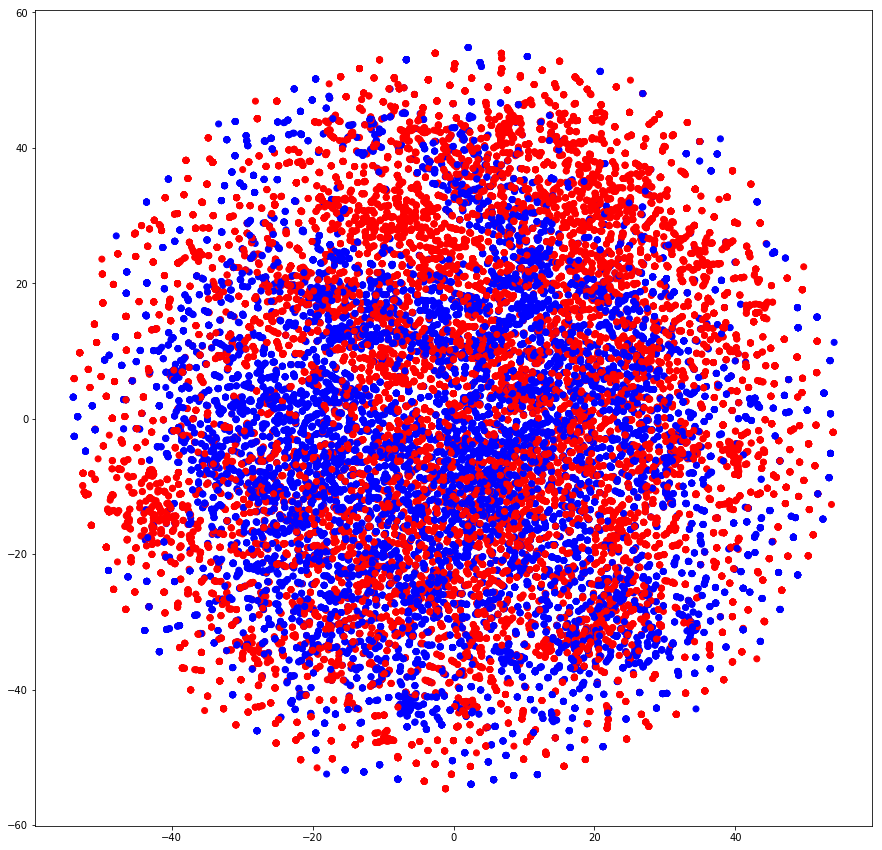

{'concurrent', 'ipython_genutils', 'selenium', 'OpenSSL', 'billiard', 'oauth2client', 'future', 'nltk', 'theano', 'pip', 'ptvsd', 'cookiecutter', 'pyhocon', 'magenta', 'msgpack', 'uritemplate', 'tensorflow', 'click', 'numpy', 'astroid', 'jsonschema', 'prompt_toolkit', 'dateutil', 'tangent', 'pylint', 'jedi', 'datadog', 'ipaddress', 'asn1crypto', 'google', 'docker', 'binaryornot', 'libfuturize', 'hyperlink', 'vcversioner', 'pywt', 'oauthlib', 'scapy', 'nbformat', 'webencodings', 'coverage', 'kombu', 'environ', 'trueskill', 'paramiko', 'setuptools', 'babel', 'mir_eval', 'matplotlib', 'PIL', 'googleapiclient', 'pandas', 'torch', 'pretty_midi', 'sortedcontainers', 'botocore', 'pbr', 'sklearn', 'smmap', 'flake8', 'sqlalchemy', 'boto', 'pyximport', 'arrow', 'traitlets', 'requests_oauthlib', 'mypy', 'sphinx', 'chardet', 'atomicwrites', 'bokeh', 'librosa', 's3transfer', 'external', 'skimage', 'hdfs', 'cycler', 'requests', 'cssselect', 'mpmath', '_pydevd_bundle', 'amqp', 'joblib', 'awscli', 'do

In [147]:
L2 = [E[x] for x in L] 
L3  = ['blue' if x not in {'tensorflow', 'sklearn', 'pandas', 'numpy', 'scipy', 'theano','torch','nltk'} else 'red' for x in L2]
plot_scatter(Y, L3)
print(set(L2))

In [148]:
l = 50
p = 30
Y2 = tsne_transform(M, perplexity=p, learning_rate=l)
TSNE_results.append((Y2,p,l))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 34568 samples in 0.367s...
[t-SNE] Computed neighbors for 34568 samples in 286.982s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34568
[t-SNE] Computed conditional probabilities for sample 2000 / 34568
[t-SNE] Computed conditional probabilities for sample 3000 / 34568
[t-SNE] Computed conditional probabilities for sample 4000 / 34568
[t-SNE] Computed conditional probabilities for sample 5000 / 34568
[t-SNE] Computed conditional probabilities for sample 6000 / 34568
[t-SNE] Computed conditional probabilities for sample 7000 / 34568
[t-SNE] Computed conditional probabilities for sample 8000 / 34568
[t-SNE] Computed conditional probabilities for sample 9000 / 34568
[t-SNE] Computed conditional probabilities for sample 10000 / 34568
[t-SNE] Computed conditional probabilities for sample 11000 / 34568
[t-SNE] Computed conditional probabilities for sample 12000 / 34568
[t-SNE] Computed conditional probabilities for s

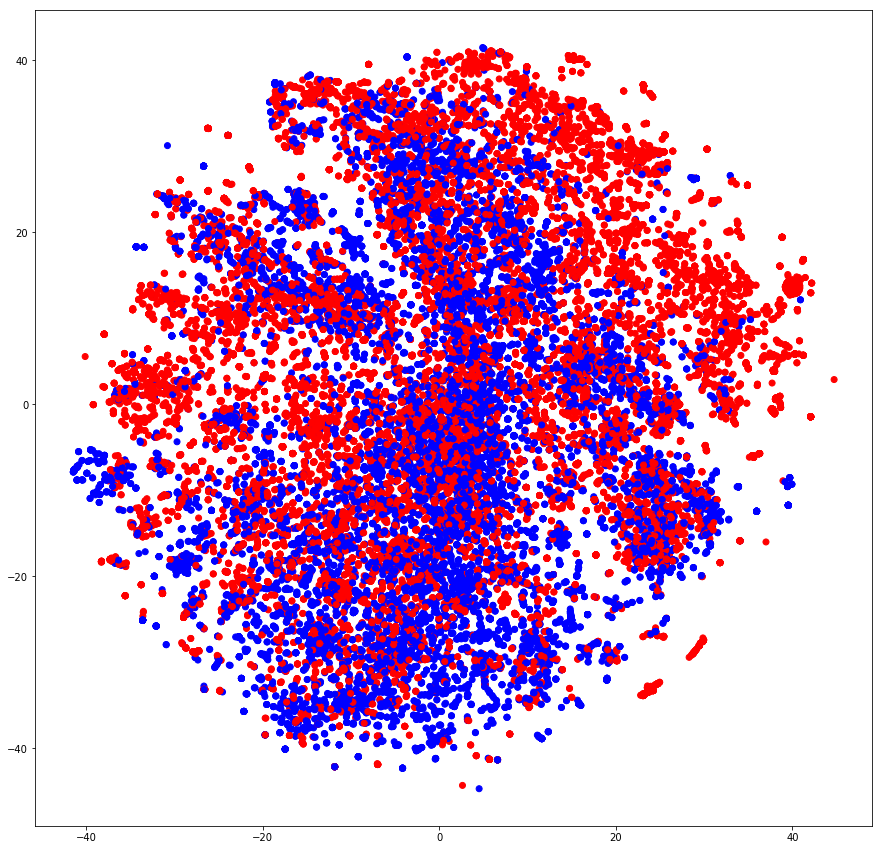

{'concurrent', 'ipython_genutils', 'selenium', 'OpenSSL', 'billiard', 'oauth2client', 'future', 'nltk', 'theano', 'pip', 'ptvsd', 'cookiecutter', 'pyhocon', 'magenta', 'msgpack', 'uritemplate', 'tensorflow', 'click', 'numpy', 'astroid', 'jsonschema', 'prompt_toolkit', 'dateutil', 'tangent', 'pylint', 'jedi', 'datadog', 'ipaddress', 'asn1crypto', 'google', 'docker', 'binaryornot', 'libfuturize', 'hyperlink', 'vcversioner', 'pywt', 'oauthlib', 'scapy', 'nbformat', 'webencodings', 'coverage', 'kombu', 'environ', 'trueskill', 'paramiko', 'setuptools', 'babel', 'mir_eval', 'matplotlib', 'PIL', 'googleapiclient', 'pandas', 'torch', 'pretty_midi', 'sortedcontainers', 'botocore', 'pbr', 'sklearn', 'smmap', 'flake8', 'sqlalchemy', 'boto', 'pyximport', 'arrow', 'traitlets', 'requests_oauthlib', 'mypy', 'sphinx', 'chardet', 'atomicwrites', 'bokeh', 'librosa', 's3transfer', 'external', 'skimage', 'hdfs', 'cycler', 'requests', 'cssselect', 'mpmath', '_pydevd_bundle', 'amqp', 'joblib', 'awscli', 'do

In [149]:
L2 = [E[x] for x in L] 
L3  = ['blue' if x not in {'tensorflow', 'sklearn', 'pandas', 'numpy', 'scipy', 'theano','torch','nltk'} else 'red' for x in L2]
plot_scatter(Y2, L3)
print(set(L2))

In [150]:
l = 10
p = 30
Y3 = tsne_transform(M, perplexity=p, learning_rate=l)
TSNE_results.append((Y3,p,l))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 34568 samples in 0.355s...
[t-SNE] Computed neighbors for 34568 samples in 285.636s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34568
[t-SNE] Computed conditional probabilities for sample 2000 / 34568
[t-SNE] Computed conditional probabilities for sample 3000 / 34568
[t-SNE] Computed conditional probabilities for sample 4000 / 34568
[t-SNE] Computed conditional probabilities for sample 5000 / 34568
[t-SNE] Computed conditional probabilities for sample 6000 / 34568
[t-SNE] Computed conditional probabilities for sample 7000 / 34568
[t-SNE] Computed conditional probabilities for sample 8000 / 34568
[t-SNE] Computed conditional probabilities for sample 9000 / 34568
[t-SNE] Computed conditional probabilities for sample 10000 / 34568
[t-SNE] Computed conditional probabilities for sample 11000 / 34568
[t-SNE] Computed conditional probabilities for sample 12000 / 34568
[t-SNE] Computed conditional probabilities for s

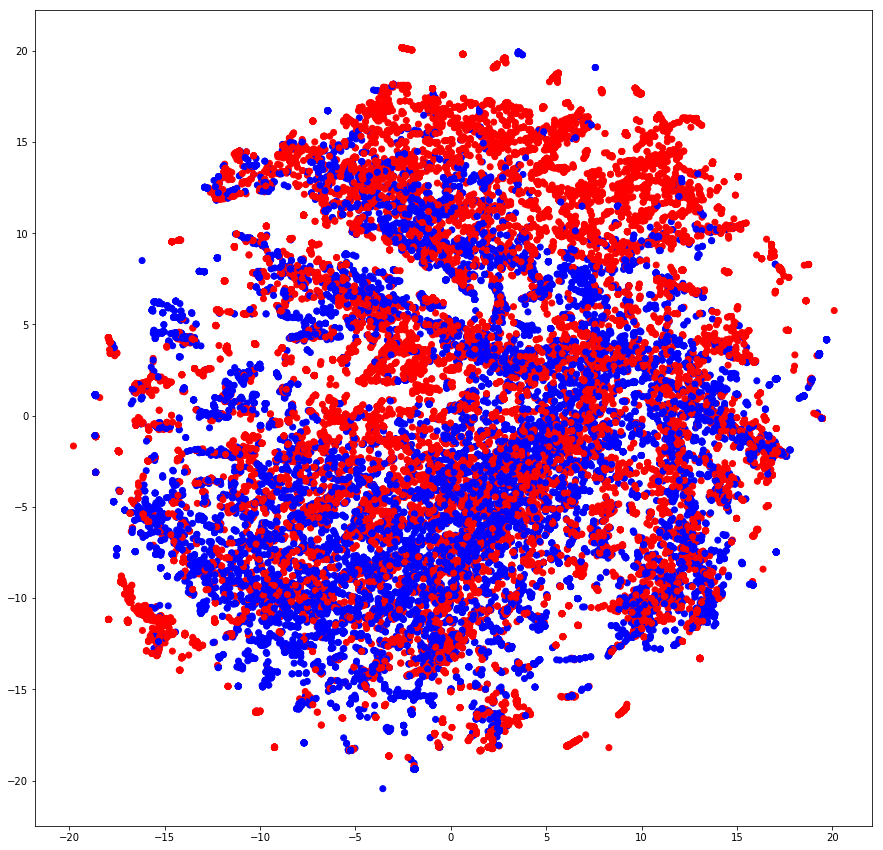

{'concurrent', 'ipython_genutils', 'selenium', 'OpenSSL', 'billiard', 'oauth2client', 'future', 'nltk', 'theano', 'pip', 'ptvsd', 'cookiecutter', 'pyhocon', 'magenta', 'msgpack', 'uritemplate', 'tensorflow', 'click', 'numpy', 'astroid', 'jsonschema', 'prompt_toolkit', 'dateutil', 'tangent', 'pylint', 'jedi', 'datadog', 'ipaddress', 'asn1crypto', 'google', 'docker', 'binaryornot', 'libfuturize', 'hyperlink', 'vcversioner', 'pywt', 'oauthlib', 'scapy', 'nbformat', 'webencodings', 'coverage', 'kombu', 'environ', 'trueskill', 'paramiko', 'setuptools', 'babel', 'mir_eval', 'matplotlib', 'PIL', 'googleapiclient', 'pandas', 'torch', 'pretty_midi', 'sortedcontainers', 'botocore', 'pbr', 'sklearn', 'smmap', 'flake8', 'sqlalchemy', 'boto', 'pyximport', 'arrow', 'traitlets', 'requests_oauthlib', 'mypy', 'sphinx', 'chardet', 'atomicwrites', 'bokeh', 'librosa', 's3transfer', 'external', 'skimage', 'hdfs', 'cycler', 'requests', 'cssselect', 'mpmath', '_pydevd_bundle', 'amqp', 'joblib', 'awscli', 'do

In [151]:
L2 = [E[x] for x in L] 
L3  = ['blue' if x not in {'tensorflow', 'sklearn', 'pandas', 'numpy', 'scipy', 'theano','torch','nltk'} else 'red' for x in L2]
plot_scatter(Y3, L3)
print(set(L2))

In [152]:
l = 50
p = 50
Y4 = tsne_transform(M, perplexity=p, learning_rate=l)
TSNE_results.append((Y4,p,l))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 34568 samples in 0.397s...
[t-SNE] Computed neighbors for 34568 samples in 330.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34568
[t-SNE] Computed conditional probabilities for sample 2000 / 34568
[t-SNE] Computed conditional probabilities for sample 3000 / 34568
[t-SNE] Computed conditional probabilities for sample 4000 / 34568
[t-SNE] Computed conditional probabilities for sample 5000 / 34568
[t-SNE] Computed conditional probabilities for sample 6000 / 34568
[t-SNE] Computed conditional probabilities for sample 7000 / 34568
[t-SNE] Computed conditional probabilities for sample 8000 / 34568
[t-SNE] Computed conditional probabilities for sample 9000 / 34568
[t-SNE] Computed conditional probabilities for sample 10000 / 34568
[t-SNE] Computed conditional probabilities for sample 11000 / 34568
[t-SNE] Computed conditional probabilities for sample 12000 / 34568
[t-SNE] Computed conditional probabilities for 

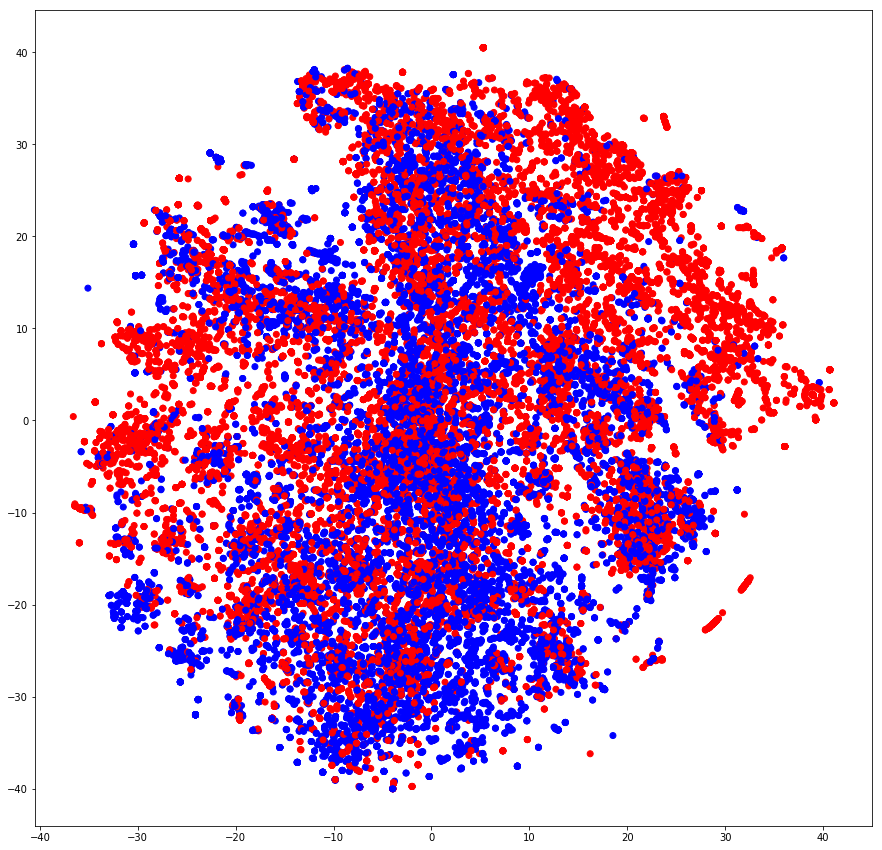

In [156]:
L2 = [E[x] for x in L] 
L3  = ['blue' if x not in {'tensorflow', 'sklearn', 'pandas', 'numpy', 'scipy', 'theano','torch','nltk'} else 'red' for x in L2]
plot_scatter(Y4, L3)


In [159]:
l = 10
p = 100
Y4 = tsne_transform(M, perplexity=p, learning_rate=l, iterations=5000)
TSNE_results.append((Y4,p,l))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 34568 samples in 0.466s...
[t-SNE] Computed neighbors for 34568 samples in 359.260s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34568
[t-SNE] Computed conditional probabilities for sample 2000 / 34568
[t-SNE] Computed conditional probabilities for sample 3000 / 34568
[t-SNE] Computed conditional probabilities for sample 4000 / 34568
[t-SNE] Computed conditional probabilities for sample 5000 / 34568
[t-SNE] Computed conditional probabilities for sample 6000 / 34568
[t-SNE] Computed conditional probabilities for sample 7000 / 34568
[t-SNE] Computed conditional probabilities for sample 8000 / 34568
[t-SNE] Computed conditional probabilities for sample 9000 / 34568
[t-SNE] Computed conditional probabilities for sample 10000 / 34568
[t-SNE] Computed conditional probabilities for sample 11000 / 34568
[t-SNE] Computed conditional probabilities for sample 12000 / 34568
[t-SNE] Computed conditional probabilities for 

[t-SNE] Iteration 2950: error = 2.0239904, gradient norm = 0.0000726 (50 iterations in 102.912s)
[t-SNE] Iteration 3000: error = 2.0178156, gradient norm = 0.0000710 (50 iterations in 104.184s)
[t-SNE] Iteration 3050: error = 2.0119214, gradient norm = 0.0000695 (50 iterations in 104.783s)
[t-SNE] Iteration 3100: error = 2.0062056, gradient norm = 0.0000683 (50 iterations in 102.892s)
[t-SNE] Iteration 3150: error = 2.0006924, gradient norm = 0.0000667 (50 iterations in 101.918s)
[t-SNE] Iteration 3200: error = 1.9946736, gradient norm = 0.0000652 (50 iterations in 102.203s)
[t-SNE] Iteration 3250: error = 1.9886367, gradient norm = 0.0000638 (50 iterations in 101.748s)
[t-SNE] Iteration 3300: error = 1.9826332, gradient norm = 0.0000628 (50 iterations in 103.258s)
[t-SNE] Iteration 3350: error = 1.9763557, gradient norm = 0.0000617 (50 iterations in 103.989s)
[t-SNE] Iteration 3400: error = 1.9705316, gradient norm = 0.0000605 (50 iterations in 104.681s)
[t-SNE] Iteration 3450: error 

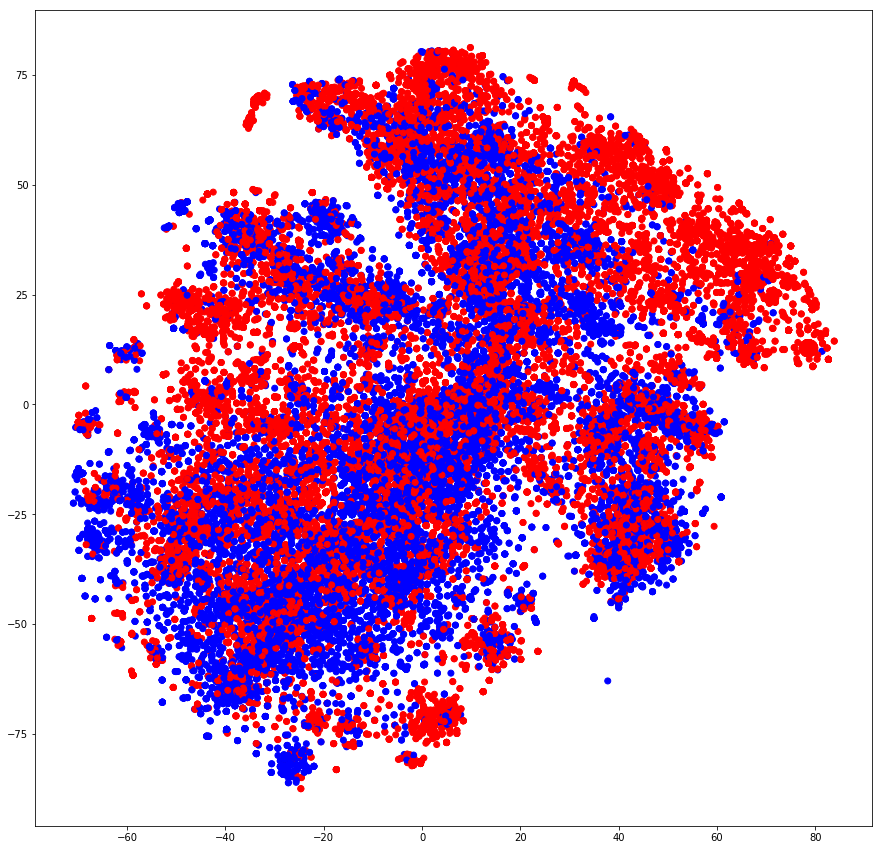

In [160]:
L2 = [E[x] for x in L] 
L3  = ['blue' if x not in {'tensorflow', 'sklearn', 'pandas', 'numpy', 'scipy', 'theano','torch','nltk'} else 'red' for x in L2]
plot_scatter(Y4, L3)


In [161]:
for p,l in [(150, 10), (100,5)]:
    Y5 = tsne_transform(M, perplexity=p, learning_rate=l, iterations=5000)
    TSNE_results.append((Y5,p,l))

[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 34568 samples in 0.395s...
[t-SNE] Computed neighbors for 34568 samples in 366.905s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34568
[t-SNE] Computed conditional probabilities for sample 2000 / 34568
[t-SNE] Computed conditional probabilities for sample 3000 / 34568
[t-SNE] Computed conditional probabilities for sample 4000 / 34568
[t-SNE] Computed conditional probabilities for sample 5000 / 34568
[t-SNE] Computed conditional probabilities for sample 6000 / 34568
[t-SNE] Computed conditional probabilities for sample 7000 / 34568
[t-SNE] Computed conditional probabilities for sample 8000 / 34568
[t-SNE] Computed conditional probabilities for sample 9000 / 34568
[t-SNE] Computed conditional probabilities for sample 10000 / 34568
[t-SNE] Computed conditional probabilities for sample 11000 / 34568
[t-SNE] Computed conditional probabilities for sample 12000 / 34568
[t-SNE] Computed conditional probabilities for 

[t-SNE] Iteration 2950: error = 1.8320178, gradient norm = 0.0000653 (50 iterations in 143.933s)
[t-SNE] Iteration 3000: error = 1.8262892, gradient norm = 0.0000640 (50 iterations in 145.784s)
[t-SNE] Iteration 3050: error = 1.8209591, gradient norm = 0.0000625 (50 iterations in 146.145s)
[t-SNE] Iteration 3100: error = 1.8159854, gradient norm = 0.0000612 (50 iterations in 144.822s)
[t-SNE] Iteration 3150: error = 1.8106948, gradient norm = 0.0000605 (50 iterations in 144.347s)
[t-SNE] Iteration 3200: error = 1.8054824, gradient norm = 0.0000592 (50 iterations in 146.312s)
[t-SNE] Iteration 3250: error = 1.8005543, gradient norm = 0.0000580 (50 iterations in 145.138s)
[t-SNE] Iteration 3300: error = 1.7960443, gradient norm = 0.0000572 (50 iterations in 144.042s)
[t-SNE] Iteration 3350: error = 1.7912320, gradient norm = 0.0000563 (50 iterations in 144.606s)
[t-SNE] Iteration 3400: error = 1.7866880, gradient norm = 0.0000555 (50 iterations in 144.688s)
[t-SNE] Iteration 3450: error 

[t-SNE] Iteration 750: error = 2.9591427, gradient norm = 0.0006502 (50 iterations in 105.843s)
[t-SNE] Iteration 800: error = 2.9025297, gradient norm = 0.0005904 (50 iterations in 105.157s)
[t-SNE] Iteration 850: error = 2.8528378, gradient norm = 0.0005406 (50 iterations in 104.427s)
[t-SNE] Iteration 900: error = 2.8069787, gradient norm = 0.0005016 (50 iterations in 102.928s)
[t-SNE] Iteration 950: error = 2.7666450, gradient norm = 0.0004639 (50 iterations in 103.640s)
[t-SNE] Iteration 1000: error = 2.7296879, gradient norm = 0.0004338 (50 iterations in 104.165s)
[t-SNE] Iteration 1050: error = 2.6948266, gradient norm = 0.0004057 (50 iterations in 104.764s)
[t-SNE] Iteration 1100: error = 2.6634994, gradient norm = 0.0003813 (50 iterations in 105.998s)
[t-SNE] Iteration 1150: error = 2.6331606, gradient norm = 0.0003611 (50 iterations in 105.339s)
[t-SNE] Iteration 1200: error = 2.6064930, gradient norm = 0.0003406 (50 iterations in 105.700s)
[t-SNE] Iteration 1250: error = 2.5

[t-SNE] Iteration 5000: error = 1.9534135, gradient norm = 0.0000560 (50 iterations in 98.915s)
[t-SNE] Error after 5000 iterations: 1.953413
perplexity=100 in 1.1e+04 sec


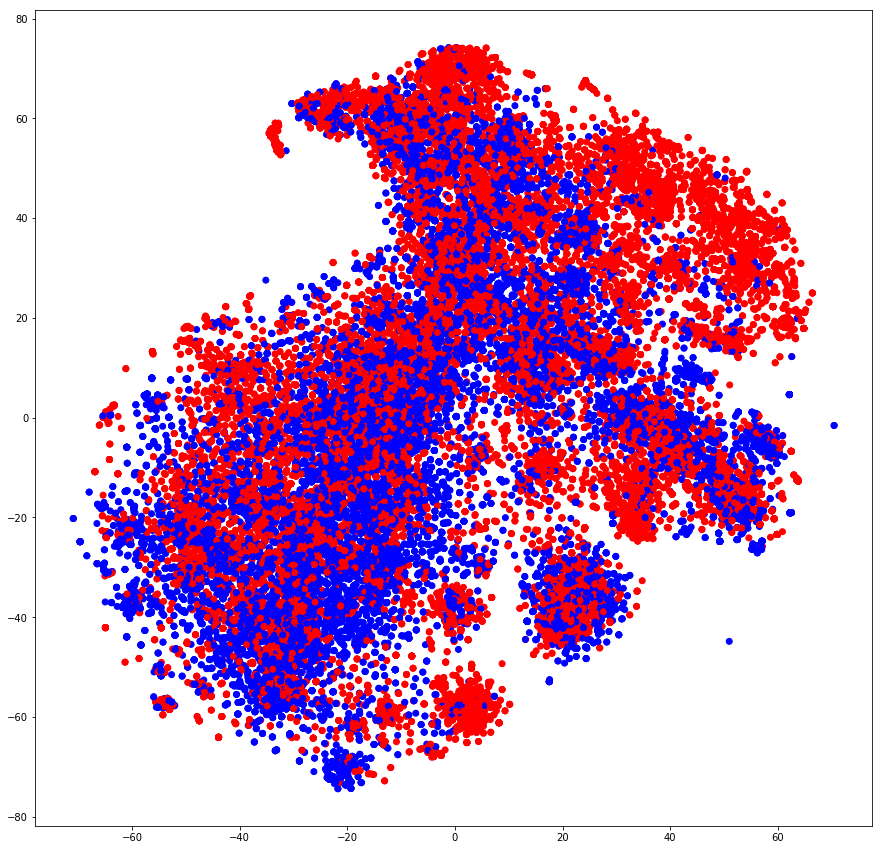

In [162]:
plot_scatter(TSNE_results[-2][0], L3)

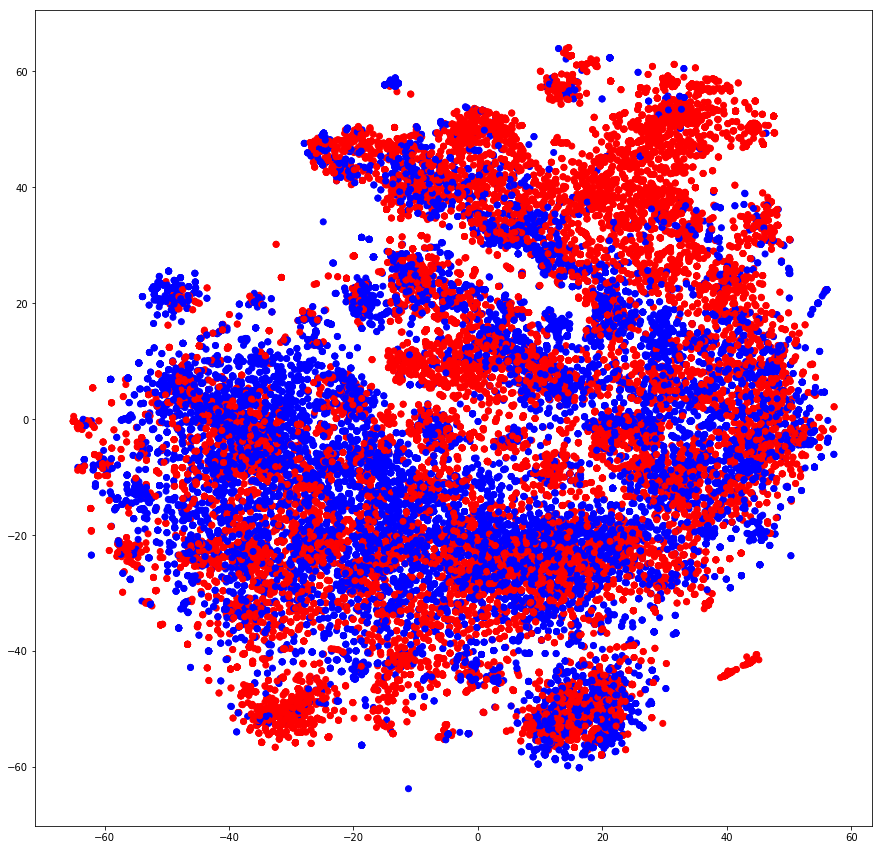

In [163]:
plot_scatter(TSNE_results[-1][0], L3)